<a href="https://colab.research.google.com/github/AlkaidCheng/GSoC2021_QMLHEP/blob/main/examples/second_round/GSoC2021_T03_QGAN_Pure_PQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install tensorflow==2.4.1
    !pip install tensorflow-quantum
    !pip install quple

In [ ]:
import os
import glob
import operator
import numpy as np
import pandas
import h5py
import tensorflow as tf
import tensorflow_quantum as tfq

In [ ]:
# for reproducibility
tf.random.set_seed(2021)
np.random.seed(2021) 

# Section 1 - Data Preprocessing

## 1.1 Load Photon-Electron data

In [ ]:
# use the cern afs public path or your own path containing the training data
data_dir = "/afs/cern.ch/work/c/chlcheng/public/GSoC2021/data"
photon_path = os.path.join(data_dir, "photon.hdf5")
electron_path = os.path.join(data_dir, "electron.hdf5")

In [ ]:
# load photon data
with h5py.File(photon_path, "r") as f:
    px = np.asarray(f['X'][()], dtype=np.float32)[:,:,:,0]
    py = np.asarray(f['y'][()], dtype=np.float32)

# load electron data
with h5py.File(electron_path, "r") as f:
    ex = np.asarray(f['X'][()], dtype=np.float32)[:,:,:,0]
    ey = np.asarray(f['y'][()], dtype=np.float32)

## 1.2 Image Visualization

In [ ]:
particle_label_map = {
    0: 'photon',
    1: 'electron'
}
import matplotlib.pyplot as plt
def vitualize_image(img, labels, name=None):
    columns = 8
    size = img.shape[0]
    rows = ( size // columns ) + 1
    fig = plt.figure(figsize=(20, rows*3))
    plt.subplots_adjust(hspace=0.3)
    for i in range(img.shape[0]):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title('Image {}: {}'.format(i+1, particle_label_map[labels[i]]))
        plt.imshow(img[i])
    if name is not None:
        plt.savefig(name, bbox_inches="tight")
    return plt

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

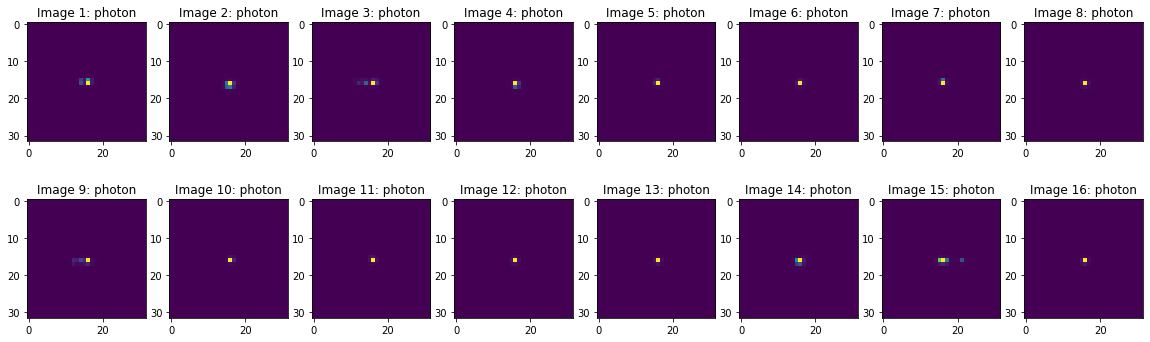

In [ ]:
# let's just visualize the photon image
vitualize_image(px[:16], py[:16], name="images/raw_image_photon.pdf")

## 1.3 Prepare Training Dataset

- Let's just train on the photon data first and split the data into 75% train and 25% test

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(px, py, train_size=0.75, test_size=0.25, random_state=2021)

## 1.4 Image Cropping

Note that the image is
1. Mostly empty except at the center
2. All jets are centered and aligned in the same direction (horizontally)

That means we can crop out the central region of the image without losing much information about the jet. And we don't need to rotate the image.

So by inspection, it should be safe to **crop out the central (8x8) grid**.

In [ ]:
def crop_image(img, dimension):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, dimension))
    end = tuple(map(operator.add, start, dimension))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [ ]:
crop_size = (8, 8)
x_train_cropped = np.array([crop_image(i, crop_size) for i in x_train])
x_test_cropped = np.array([crop_image(i, crop_size) for i in x_test])

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

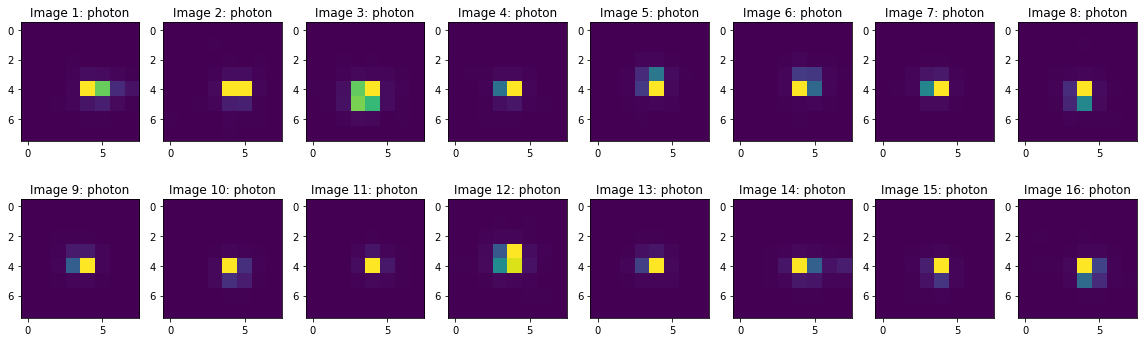

In [ ]:
vitualize_image(x_train_cropped[:16], y_train[:16],  name="images/cropped_image_photon.pdf")

## 1.5 Image Compression

Still the image size (8x8) = 64 is too large to be fed to the quantum circuit. 

A more reasonable size will be (4x4) = 16 which requires 16 qubits to encode the image (if we are using quantum generator, it is easiest to have 1 qubit generating 1 pixel)

In [ ]:
# add the color channel
x_train_ = np.reshape(x_train_cropped, list(x_train_cropped.shape)+[1])
x_test_ = np.reshape(x_test_cropped, list(x_test_cropped.shape)+[1])
# here we will use the image resize function from tensorflow for compressing the image
x_train_small = np.array([tf.image.resize(img, (4,4)).numpy() for img in x_train_])
x_test_small = np.array([tf.image.resize(img, (4,4)).numpy() for img in x_test_])
x_train_small = np.reshape(x_train_small, x_train_small.shape[:3])
x_test_small = np.reshape(x_test_small, x_test_small.shape[:3])

In [ ]:
image_shape = x_train_small.shape[1:]
image_shape

(4, 4)

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

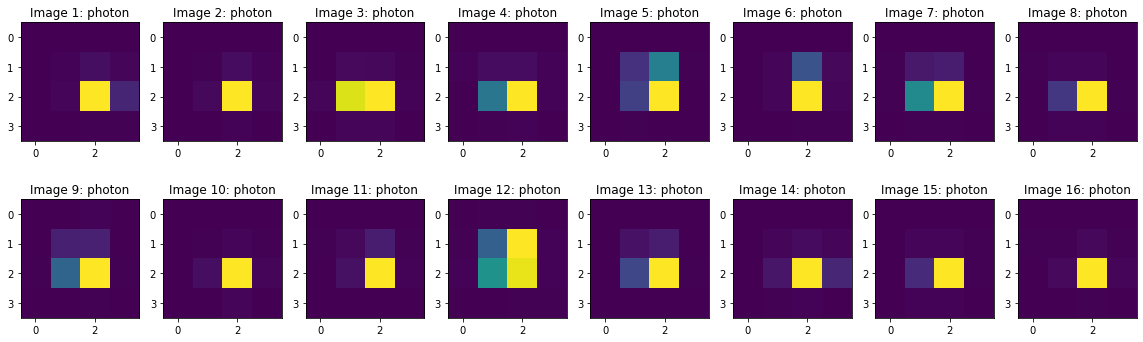

In [ ]:
# let's see how the compressed images look
vitualize_image(x_train_small[:16], y_train[:16])

## 1.6 Rescale data to the range appropriate for quantum data encoding

- Usually classical data is encoded as the rotation angle of a gate operation in a quantum circuit which has a valid range of $[-\pi,+\pi]$. However, from past experience a smaller range will suffice and even show better performance than the valid range itself. So for this task, we will be **rescaling our data to a unit range (i.e. $[-1, +1]$)** following the range used by https://arxiv.org/abs/1906.10467. Alternatively, one may also use another common range $[0, +1]$ for example from the`tensorflow_quantum` tutorial for MNIST classification (https://www.tensorflow.org/quantum/tutorials/mnist)

In [ ]:
def rescale_data(*data, val_range = (0, 1.)):
    min_value = np.min([np.min(d) for d in data])
    max_value = np.max([np.max(d) for d in data])
    range_min = val_range[0]
    range_max = val_range[1]
    rescaled_data = tuple([(((d-min_value)/(max_value-min_value))*(range_max-range_min))+range_min for d in data])
    return rescaled_data
x_train_rescaled, x_test_rescaled = rescale_data(x_train_small, x_test_small, val_range=(0, 1))
x_train_final = np.reshape(x_train_rescaled, (x_train_rescaled.shape[0], 16))
x_test_final = np.reshape(x_test_rescaled, (x_test_rescaled.shape[0], 16))

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


# Section 2 - QGAN Model Building

In [ ]:
# since the image has 16 pixels, we can use 16 qubits to represent each pixel
n_qubit = feature_dimension = 16

## 2.1 Create Data Circuit

- The data circuit is responsible for encoding classical data into quantum state of a the circuit

In [ ]:
from quple.data_encoding import FirstOrderPauliZEncoding

# let's just try the simplest form of encoding, 
# i.e. a layer of H followed by Rz rotation with angle parameterized by the classical input
encoding_circuit = FirstOrderPauliZEncoding(feature_dimension=feature_dimension, parameter_scale=1,
                                            copies=2)
encoding_circuit

(0, 0): ────H───Rz(pi*<x_0/pi>)────H───Rz(pi*<x_0/pi>)────

(0, 1): ────H───Rz(pi*<x_1/pi>)────H───Rz(pi*<x_1/pi>)────

(0, 2): ────H───Rz(pi*<x_2/pi>)────H───Rz(pi*<x_2/pi>)────

(0, 3): ────H───Rz(pi*<x_3/pi>)────H───Rz(pi*<x_3/pi>)────

(0, 4): ────H───Rz(pi*<x_4/pi>)────H───Rz(pi*<x_4/pi>)────

(0, 5): ────H───Rz(pi*<x_5/pi>)────H───Rz(pi*<x_5/pi>)────

(0, 6): ────H───Rz(pi*<x_6/pi>)────H───Rz(pi*<x_6/pi>)────

(0, 7): ────H───Rz(pi*<x_7/pi>)────H───Rz(pi*<x_7/pi>)────

(0, 8): ────H───Rz(pi*<x_8/pi>)────H───Rz(pi*<x_8/pi>)────

(0, 9): ────H───Rz(pi*<x_9/pi>)────H───Rz(pi*<x_9/pi>)────

(0, 10): ───H───Rz(pi*<x_10/pi>)───H───Rz(pi*<x_10/pi>)───

(0, 11): ───H───Rz(pi*<x_11/pi>)───H───Rz(pi*<x_11/pi>)───

(0, 12): ───H───Rz(pi*<x_12/pi>)───H───Rz(pi*<x_12/pi>)───

(0, 13): ───H───Rz(pi*<x_13/pi>)───H───Rz(pi*<x_13/pi>)───

(0, 14): ───H───Rz(pi*<x_14/pi>)───H───Rz(pi*<x_14/pi>)───

(0, 15): ───H───Rz(pi*<x_15/pi>)───H───Rz(pi*<x_15/pi>)───

## 2.2 Create Generator and Discriminator Circuit

- We will use parameterised quantum circuits (PQCs) as quantum analog of a neural network
- A PQC is made up of a series of parameterized local single-qubit rotations and two-qubit entagling operations in which the circuit parameters represent the weights of a neural network.
- The generator circuit $\mathbf{G}$ takes as input a random Gaussian noise vector $\mathbf{z}$ (the set of possible values taken by $\mathbf{z}$ is called the latent space which has the same dimension as a real data vector $\mathbf{x}$ and outputs a fake data $\mathbf{x}_{g}=G(\mathbf{z})$ where $G$ denotes the transformation (i.e. the neural net) made by $\mathbf{G}$. 
- The discriminator circuit $\mathbf{D}$ takes independently as input the real data $\mathbf{x}$ and the fake data $G(\mathbf{z})$ and outputs the values $D(\mathbf{x})$ and $D(G(\mathbf{z}))$ where $D$ denotes the transformation made by $\mathbf{D}$. In our case, the value of $D$ represent the probabilty of the input being true. 

In [ ]:
from quple import ParameterisedCircuit
# let's make a simple PQC for the generator circuit
generator_circuit = ParameterisedCircuit(n_qubit=n_qubit, copies=2,
                                         rotation_blocks=['RY', 'RZ'],
                                         entanglement_blocks = ['CX'],
                                         entangle_strategy='alternate_linear',
                                         final_rotation_layer=True)
generator_circuit

(0, 0): ────Ry(θ_0)────Rz(θ_16)───@───Ry(θ_32)───Rz(θ_48)──────────────@───Ry(θ_64)───Rz(θ_80)──────────────
                                  │                                    │
(0, 1): ────Ry(θ_1)────Rz(θ_17)───X───@──────────Ry(θ_33)───Rz(θ_49)───X───@──────────Ry(θ_65)───Rz(θ_81)───
                                      │                                    │
(0, 2): ────Ry(θ_2)────Rz(θ_18)───@───X──────────Ry(θ_34)───Rz(θ_50)───@───X──────────Ry(θ_66)───Rz(θ_82)───
                                  │                                    │
(0, 3): ────Ry(θ_3)────Rz(θ_19)───X───@──────────Ry(θ_35)───Rz(θ_51)───X───@──────────Ry(θ_67)───Rz(θ_83)───
                                      │                                    │
(0, 4): ────Ry(θ_4)────Rz(θ_20)───@───X──────────Ry(θ_36)───Rz(θ_52)───@───X──────────Ry(θ_68)───Rz(θ_84)───
                                  │                                    │
(0, 5): ────Ry(θ_5)────Rz(θ_21)───X───@──────────Ry(θ_37)───Rz(θ_53)───X───@──────────Ry(θ_69)───Rz(θ_85)───
                                      │                                    │
(0, 6): ────Ry(θ_6)────Rz(θ_22)───@───X──────────Ry(θ_38)───Rz(θ_54)───@───X──────────Ry(θ_70)───Rz(θ_86)───
                                  │                                    │
(0, 7): ────Ry(θ_7)────Rz(θ_23)───X───@──────────Ry(θ_39)───Rz(θ_55)───X───@──────────Ry(θ_71)───Rz(θ_87)───
                                      │                                    │
(0, 8): ────Ry(θ_8)────Rz(θ_24)───@───X──────────Ry(θ_40)───Rz(θ_56)───@───X──────────Ry(θ_72)───Rz(θ_88)───
                                  │                                    │
(0, 9): ────Ry(θ_9)────Rz(θ_25)───X───@──────────Ry(θ_41)───Rz(θ_57)───X───@──────────Ry(θ_73)───Rz(θ_89)───
                                      │                                    │
(0, 10): ───Ry(θ_10)───Rz(θ_26)───@───X──────────Ry(θ_42)───Rz(θ_58)───@───X──────────Ry(θ_74)───Rz(θ_90)───
                                  │                                    │
(0, 11): ───Ry(θ_11)───Rz(θ_27)───X───@──────────Ry(θ_43)───Rz(θ_59)───X───@──────────Ry(θ_75)───Rz(θ_91)───
                                      │                                    │
(0, 12): ───Ry(θ_12)───Rz(θ_28)───@───X──────────Ry(θ_44)───Rz(θ_60)───@───X──────────Ry(θ_76)───Rz(θ_92)───
                                  │                                    │
(0, 13): ───Ry(θ_13)───Rz(θ_29)───X───@──────────Ry(θ_45)───Rz(θ_61)───X───@──────────Ry(θ_77)───Rz(θ_93)───
                                      │                                    │
(0, 14): ───Ry(θ_14)───Rz(θ_30)───@───X──────────Ry(θ_46)───Rz(θ_62)───@───X──────────Ry(θ_78)───Rz(θ_94)───
                                  │                                    │
(0, 15): ───Ry(θ_15)───Rz(θ_31)───X──────────────Ry(θ_47)───Rz(θ_63)───X──────────────Ry(θ_79)───Rz(θ_95)───

In [ ]:
from quple import ParameterisedCircuit
# another arbitrary pqc for discriminator circuit
discriminator_circuit = ParameterisedCircuit(n_qubit=n_qubit, copies=2,
                                             rotation_blocks=['RZ', 'RY'],
                                             entanglement_blocks = ['ZZ'],
                                             entangle_strategy='alternate_linear',
                                             final_rotation_layer=True)
discriminator_circuit

(0, 0): ────Rz(θ_0)────Ry(θ_16)───ZZ──────────Rz(θ_47)────Ry(θ_63)──────────────ZZ──────────Rz(θ_94)────Ry(θ_110)───────────────
                                  │                                             │
(0, 1): ────Rz(θ_1)────Ry(θ_17)───ZZ^(θ_32)───ZZ──────────Rz(θ_48)───Ry(θ_64)───ZZ^(θ_79)───ZZ──────────Rz(θ_95)────Ry(θ_111)───
                                              │                                             │
(0, 2): ────Rz(θ_2)────Ry(θ_18)───ZZ──────────ZZ^(θ_40)───Rz(θ_49)───Ry(θ_65)───ZZ──────────ZZ^(θ_87)───Rz(θ_96)────Ry(θ_112)───
                                  │                                             │
(0, 3): ────Rz(θ_3)────Ry(θ_19)───ZZ^(θ_33)───ZZ──────────Rz(θ_50)───Ry(θ_66)───ZZ^(θ_80)───ZZ──────────Rz(θ_97)────Ry(θ_113)───
                                              │                                             │
(0, 4): ────Rz(θ_4)────Ry(θ_20)───ZZ──────────ZZ^(θ_41)───Rz(θ_51)───Ry(θ_67)───ZZ──────────ZZ^(θ_88)───Rz(θ_98)────Ry(θ_114)───
                                  │                                             │
(0, 5): ────Rz(θ_5)────Ry(θ_21)───ZZ^(θ_34)───ZZ──────────Rz(θ_52)───Ry(θ_68)───ZZ^(θ_81)───ZZ──────────Rz(θ_99)────Ry(θ_115)───
                                              │                                             │
(0, 6): ────Rz(θ_6)────Ry(θ_22)───ZZ──────────ZZ^(θ_42)───Rz(θ_53)───Ry(θ_69)───ZZ──────────ZZ^(θ_89)───Rz(θ_100)───Ry(θ_116)───
                                  │                                             │
(0, 7): ────Rz(θ_7)────Ry(θ_23)───ZZ^(θ_35)───ZZ──────────Rz(θ_54)───Ry(θ_70)───ZZ^(θ_82)───ZZ──────────Rz(θ_101)───Ry(θ_117)───
                                              │                                             │
(0, 8): ────Rz(θ_8)────Ry(θ_24)───ZZ──────────ZZ^(θ_43)───Rz(θ_55)───Ry(θ_71)───ZZ──────────ZZ^(θ_90)───Rz(θ_102)───Ry(θ_118)───
                                  │                                             │
(0, 9): ────Rz(θ_9)────Ry(θ_25)───ZZ^(θ_36)───ZZ──────────Rz(θ_56)───Ry(θ_72)───ZZ^(θ_83)───ZZ──────────Rz(θ_103)───Ry(θ_119)───
                                              │                                             │
(0, 10): ───Rz(θ_10)───Ry(θ_26)───ZZ──────────ZZ^(θ_44)───Rz(θ_57)───Ry(θ_73)───ZZ──────────ZZ^(θ_91)───Rz(θ_104)───Ry(θ_120)───
                                  │                                             │
(0, 11): ───Rz(θ_11)───Ry(θ_27)───ZZ^(θ_37)───ZZ──────────Rz(θ_58)───Ry(θ_74)───ZZ^(θ_84)───ZZ──────────Rz(θ_105)───Ry(θ_121)───
                                              │                                             │
(0, 12): ───Rz(θ_12)───Ry(θ_28)───ZZ──────────ZZ^(θ_45)───Rz(θ_59)───Ry(θ_75)───ZZ──────────ZZ^(θ_92)───Rz(θ_106)───Ry(θ_122)───
                                  │                                             │
(0, 13): ───Rz(θ_13)───Ry(θ_29)───ZZ^(θ_38)───ZZ──────────Rz(θ_60)───Ry(θ_76)───ZZ^(θ_85)───ZZ──────────Rz(θ_107)───Ry(θ_123)───
                                              │                                             │
(0, 14): ───Rz(θ_14)───Ry(θ_30)───ZZ──────────ZZ^(θ_46)───Rz(θ_61)───Ry(θ_77)───ZZ──────────ZZ^(θ_93)───Rz(θ_108)───Ry(θ_124)───
                                  │                                             │
(0, 15): ───Rz(θ_15)───Ry(θ_31)───ZZ^(θ_39)───────────────Rz(θ_62)───Ry(θ_78)───ZZ^(θ_86)───────────────Rz(θ_109)───Ry(θ_125)───

## 2.3 Create QGAN model

- I hide all the black magic for implementing this QGAN class
- You may check the source code to see how it is implemented

In [ ]:
from quple.models import QGAN
qgan = QGAN(generator_circuit, discriminator_circuit, encoding_circuit=encoding_circuit,
            epochs=50, d_lr=1e-3, g_lr=2e-3, random_state=2021, batch_size=16,
            checkpoint_interval=10,
            checkpoint_dir="./training_checkpoints/qgan_pure_pqc/")

Summary of Generator
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_22 (PQC)                 (None, 16)                96        
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_23 (PQC)                 (None, 1)                 126       
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# enable interactive visualization
qgan.enable_visualization(image_shape, n_image=16)

## 2.4 Begin Training

- For the sake of time, use 200 samples only

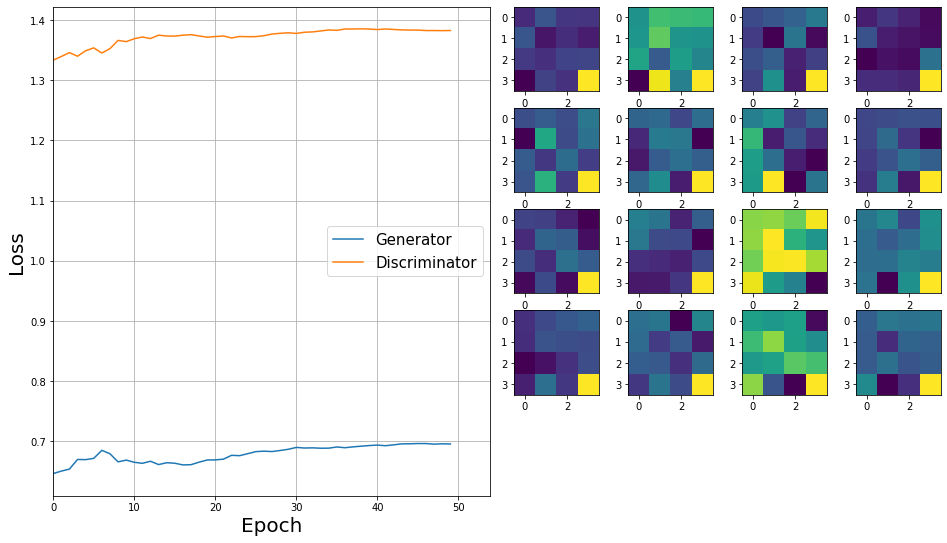

In [ ]:
g_loss, d_loss = qgan.train(x_train_final[2021:2221])